In [1]:
latest_gameweek = 0
shift_param = 1

In [2]:
import pandas as pd
import numpy as np
import optuna
import shap
from pathlib import Path
import datetime as dt
import json
import pickle

/opt/anaconda3/envs/fpl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
from src.model_training import cross_validation, optuna_objective_xgboost, plot_optuna_study, train_xgboost

In [5]:
# fetch data
filepath = Path('../data/modeling/fpl_df.csv')
fpl_df = pd.read_csv(filepath, low_memory=False)
fpl_df['data_retrieved_datetime'] = pd.to_datetime(fpl_df['data_retrieved_datetime'])
display(fpl_df.head())
display(fpl_df.shape)

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,gameweek_xA_ewm_10,gameweek_xGA_ewm_10,gameweek_minutes_ewm_10,gameweek_xPoints_ewm_10,gameweek_assists_ewm_20,gameweek_bps_ewm_20,gameweek_creativity_ewm_20,event_points_ewm_20,gameweek_goals_scored_ewm_20,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime,region,can_transact,can_s

(38128, 229)

In [6]:
fpl_df.season.value_counts()

season
24-25    11361
23-24    11005
21-22     6640
20-21     6321
22-23     2801
Name: count, dtype: int64

In [7]:
features_no_shift = ['element_type', 'home', 'opponent_xG_ewm_5', 'opponent_xG_ewm_10',
       'opponent_xG_ewm_20', 'opponent_xG_ewm_40', 'opponent_xGA_ewm_5',
       'opponent_xGA_ewm_10', 'opponent_xGA_ewm_20',
       'opponent_xGA_ewm_40', ]

features_shift = ['corners_and_indirect_freekicks_order', 'creativity_rank', 
       'direct_freekicks_order', 'ict_index_rank', 'influence_rank',
       'minutes', 'now_cost', 'penalties_order', 'points_per_game', 
       'selected_by_percent', 'threat_rank',
       'team_xG_ewm_5', 'team_xG_ewm_10', 'team_xG_ewm_20',
       'team_xG_ewm_40', 'team_xGA_ewm_5', 'team_xGA_ewm_10',
       'team_xGA_ewm_20', 'team_xGA_ewm_40', 
       'gameweek_assists_ewm_5', 'gameweek_bps_ewm_5',
       'gameweek_creativity_ewm_5', 'event_points_ewm_5',
       'gameweek_goals_scored_ewm_5', 'gameweek_goals_conceded_ewm_5',
       'gameweek_saves_ewm_5', 'gameweek_threat_ewm_5',
       'gameweek_xG_ewm_5', 'gameweek_xA_ewm_5', 'gameweek_xGA_ewm_5',
       'gameweek_minutes_ewm_5', 'gameweek_xPoints_ewm_5',
       'gameweek_assists_ewm_10', 'gameweek_bps_ewm_10',
       'gameweek_creativity_ewm_10', 'event_points_ewm_10',
       'gameweek_goals_scored_ewm_10', 'gameweek_goals_conceded_ewm_10',
       'gameweek_saves_ewm_10', 'gameweek_threat_ewm_10',
       'gameweek_xG_ewm_10', 'gameweek_xA_ewm_10', 'gameweek_xGA_ewm_10',
       'gameweek_minutes_ewm_10', 'gameweek_xPoints_ewm_10',
       'gameweek_assists_ewm_20', 'gameweek_bps_ewm_20',
       'gameweek_creativity_ewm_20', 'event_points_ewm_20',
       'gameweek_goals_scored_ewm_20', 'gameweek_goals_conceded_ewm_20',
       'gameweek_saves_ewm_20', 'gameweek_threat_ewm_20',
       'gameweek_xG_ewm_20', 'gameweek_xA_ewm_20', 'gameweek_xGA_ewm_20',
       'gameweek_minutes_ewm_20', 'gameweek_xPoints_ewm_20',
       'gameweek_assists_ewm_40', 'gameweek_bps_ewm_40',
       'gameweek_creativity_ewm_40', 'event_points_ewm_40',
       'gameweek_goals_scored_ewm_40', 'gameweek_goals_conceded_ewm_40',
       'gameweek_saves_ewm_40', 'gameweek_threat_ewm_40',
       'gameweek_xG_ewm_40', 'gameweek_xA_ewm_40', 'gameweek_xGA_ewm_40',
       'gameweek_minutes_ewm_40', 'gameweek_xPoints_ewm_40',
       'gameweek_assists_expanding', 'gameweek_bps_expanding',
       'gameweek_creativity_expanding', 'event_points_expanding',
       'gameweek_goals_scored_expanding',
       'gameweek_goals_conceded_expanding', 'gameweek_saves_expanding',
       'gameweek_threat_expanding', 'gameweek_xG_expanding',
       'gameweek_xA_expanding', 'gameweek_xGA_expanding',
       'gameweek_minutes_expanding', 'gameweek_xPoints_expanding',
       'gameweek_assists_expanding_per90', 'gameweek_bps_expanding_per90',
       'gameweek_creativity_expanding_per90',
       'event_points_expanding_per90',
       'gameweek_goals_scored_expanding_per90',
       'gameweek_goals_conceded_expanding_per90',
       'gameweek_saves_expanding_per90',
       'gameweek_threat_expanding_per90', 'gameweek_xG_expanding_per90',
       'gameweek_xA_expanding_per90', 'gameweek_xGA_expanding_per90',
       'gameweek_xPoints_expanding_per90', 'xG_overperformance'
    ]

target = ['event_points']

In [8]:
# shift given features
df = fpl_df.copy()
df[features_shift] = df.groupby(['first_name', 'second_name'])[features_shift].shift(shift_param)
display(df.head())
display(df.tail())
display(df.shape)

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,gameweek_xA_ewm_10,gameweek_xGA_ewm_10,gameweek_minutes_ewm_10,gameweek_xPoints_ewm_10,gameweek_assists_ewm_20,gameweek_bps_ewm_20,gameweek_creativity_ewm_20,event_points_ewm_20,gameweek_goals_scored_ewm_20,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime,region,can_transact,can_s

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,gameweek_xA_ewm_10,gameweek_xGA_ewm_10,gameweek_minutes_ewm_10,gameweek_xPoints_ewm_10,gameweek_assists_ewm_20,gameweek_bps_ewm_20,gameweek_creativity_ewm_20,event_points_ewm_20,gameweek_goals_scored_ewm_20,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime,region,can_transact,can_s

(38128, 229)

<Axes: ylabel='Frequency'>

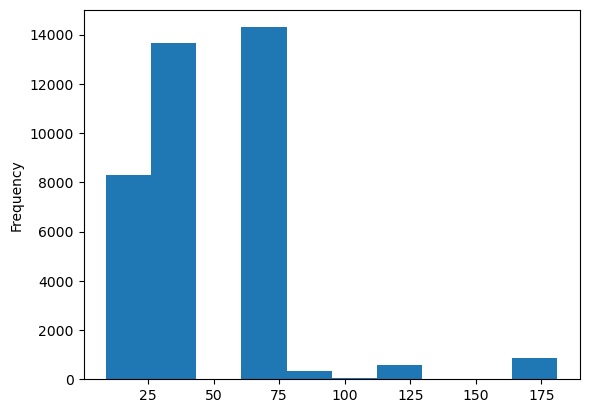

In [9]:
df.isnull().sum(axis=1).plot(kind='hist')

In [10]:
# drop rows where too much data missing
df = df[df.isnull().sum(axis=1) <= 90].reset_index(drop=True)
display(df.shape)

(36601, 229)

In [11]:
df.season.value_counts()

season
24-25    11185
23-24    10797
21-22     6438
20-21     5671
22-23     2510
Name: count, dtype: int64

## Train-test split

In [14]:
train_index = df[~(df.data_retrieved_datetime>'30-7-2024')].index
display(train_index)
test_index = df[(df.data_retrieved_datetime>'30-7-2024')].index
display(test_index)
display('Proportion of data in test set: {:.2f}'.format(len(test_index)/len(df)))

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       25406, 25407, 25408, 25409, 25410, 25411, 25412, 25413, 25414, 25415],
      dtype='int64', length=25416)

Index([25416, 25417, 25418, 25419, 25420, 25421, 25422, 25423, 25424, 25425,
       ...
       36591, 36592, 36593, 36594, 36595, 36596, 36597, 36598, 36599, 36600],
      dtype='int64', length=11185)

'Proportion of data in test set: 0.31'

In [15]:
X = df[features_no_shift+features_shift].copy()
y = df[target].copy()
X_train = df.loc[train_index, features_no_shift+features_shift].copy()
y_train = df.loc[train_index, target].copy()
X_test = df.loc[test_index, features_no_shift+features_shift].copy()
y_test = df.loc[test_index, target].copy()

## Hyper-parameter optimization

In [16]:
optuna_bounds = {}
optuna_bounds['learning_rate'] = [0.001, 0.1]
optuna_bounds['max_depth'] = [4, 10]
optuna_bounds['min_child_weight'] = [0.01, 1]
optuna_bounds['gamma'] = [0, 0.5]
optuna_bounds['subsample'] = [0.5, 1]
optuna_bounds['colsample_bytree'] = [0.5, 1]

[I 2025-08-13 08:47:58,780] A new study created in memory with name: no-name-4f4d83fc-4b69-491f-976c-dda7c676af10
[I 2025-08-13 08:48:04,004] Trial 0 finished with value: 2.8779959125016696 and parameters: {'learning_rate': 0.054087287831344324, 'max_depth': 9, 'min_child_weight': 0.42505854765098666, 'gamma': 0.3958251904140741, 'subsample': 0.6675165773911311, 'colsample_bytree': 0.6379154148457169}. Best is trial 0 with value: 2.8779959125016696.
[I 2025-08-13 08:48:05,532] Trial 1 finished with value: 2.8488781898886746 and parameters: {'learning_rate': 0.08143885423364941, 'max_depth': 4, 'min_child_weight': 0.3800950785624696, 'gamma': 0.1239527459765572, 'subsample': 0.8138009033597182, 'colsample_bytree': 0.8554322639602274}. Best is trial 1 with value: 2.8488781898886746.
[I 2025-08-13 08:48:10,964] Trial 2 finished with value: 2.895584269517433 and parameters: {'learning_rate': 0.08910148059224357, 'max_depth': 10, 'min_child_weight': 0.6243131913601497, 'gamma': 0.4184106898

OPTIMIZATION TRIALS DATA


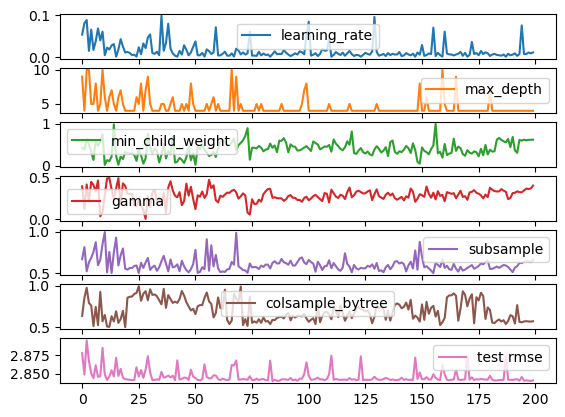

Best params:
{'learning_rate': 0.0071371238246575475, 'max_depth': 4, 'min_child_weight': 0.4249829821928075, 'gamma': 0.2574125071368928, 'subsample': 0.6226097948774205, 'colsample_bytree': 0.589856828800921}
Test logloss for best params:
2.839908742008103


In [17]:
# choose max number of trials for optimization
n_optimization_trials = 200

study = optuna.create_study()
study.optimize(
    lambda trial: optuna_objective_xgboost(trial, optuna_bounds, X_train, y_train),
    n_trials=n_optimization_trials,
    )

plot_optuna_study(study)

print('Best params:')
print(study.best_params)
print('Test logloss for best params:')
print(study.best_value)

Number of estimators: 518


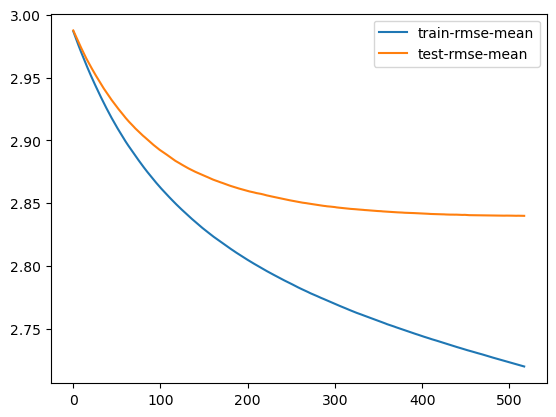

In [18]:
# find nr_estimators for best params (here test-logloss-mean is the average log-loss in cross-validation test)
cv_df = cross_validation(X_train, y_train, study.best_params)
n_estimators = cv_df.sort_values(f'test-rmse-mean').index[0] + 1
cv_df[['train-rmse-mean', 'test-rmse-mean']].plot();
print(f'Number of estimators: {n_estimators}')

## Test best model

In [19]:
xgb_params = study.best_params
xgb_params['n_estimators'] = int(n_estimators)

model, results = train_xgboost(xgb_params, X_train, y_train, X_test, y_test)

RMSE (train): 2.743293046951294
R^2 (train): 0.1578713059425354
RMSE (test): 2.743316650390625
R^2 (test): 0.1105160117149353


In [20]:
results_dict = xgb_params.copy()
results_dict['train_rmse'] = results['train_rmse']
results_dict['test_rmse'] = results['test_rmse']
results_dict['train_r2'] = results['train_r2']
results_dict['test_r2'] = results['test_r2']
results_dict

{'learning_rate': 0.0071371238246575475,
 'max_depth': 4,
 'min_child_weight': 0.4249829821928075,
 'gamma': 0.2574125071368928,
 'subsample': 0.6226097948774205,
 'colsample_bytree': 0.589856828800921,
 'n_estimators': 518,
 'train_rmse': 2.743293046951294,
 'test_rmse': 2.743316650390625,
 'train_r2': 0.1578713059425354,
 'test_r2': 0.1105160117149353}

PermutationExplainer explainer: 2001it [03:25,  9.35it/s]                          


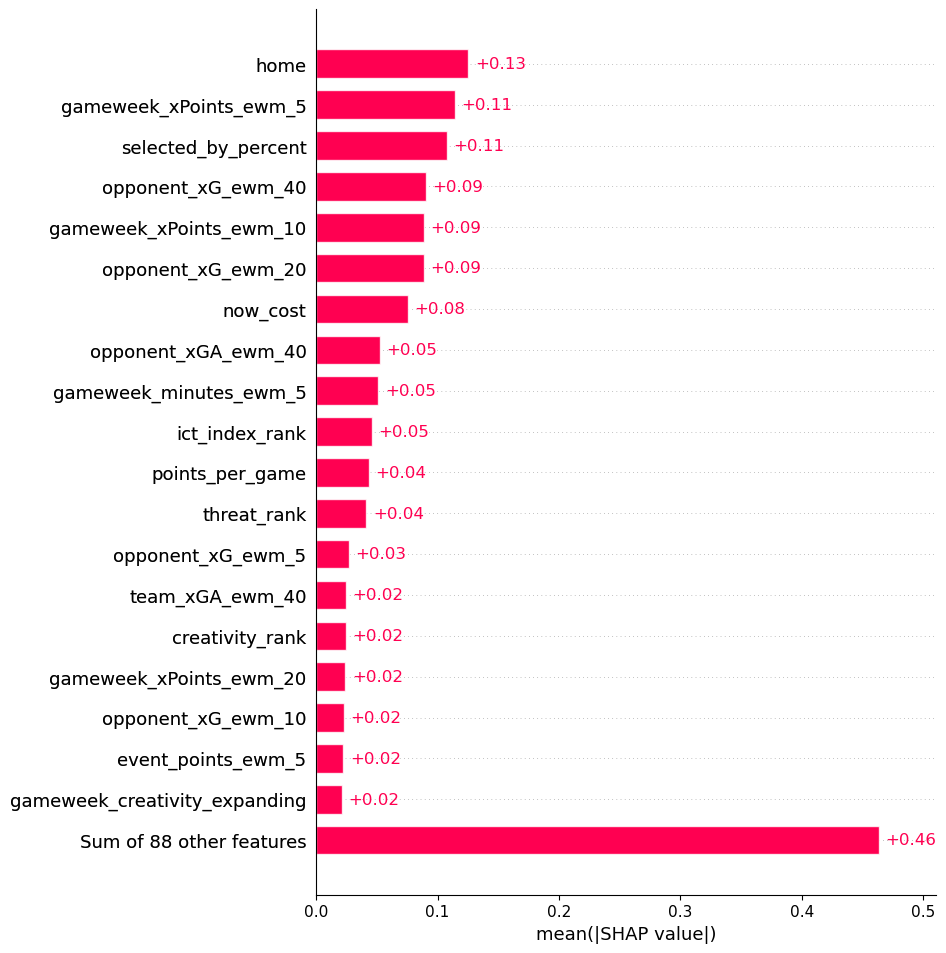

In [21]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train.sample(2000, random_state=42))
shap.plots.bar(shap_values, max_display=20)

## Train model with full data and save model

In [22]:
model, results = train_xgboost(xgb_params, X, y)

RMSE (train): 2.738837242126465
R^2 (train): 0.14706122875213623


PermutationExplainer explainer: 2001it [03:21,  9.43it/s]                          


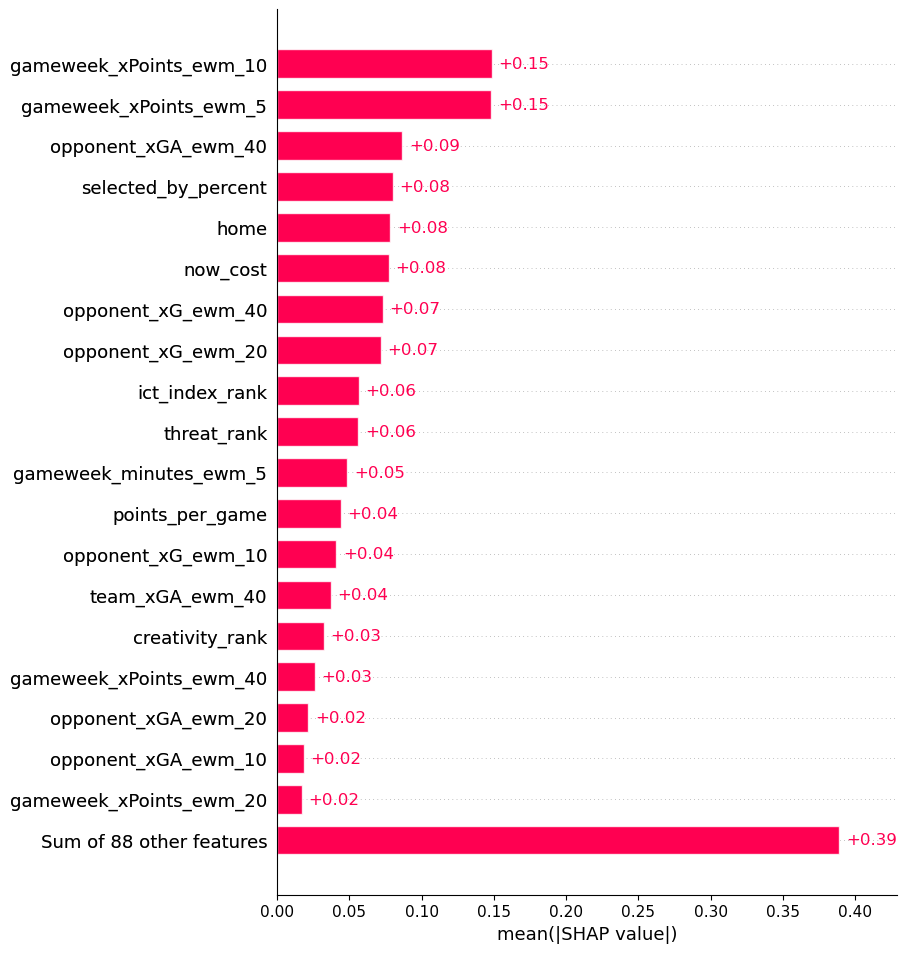

In [23]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X.sample(2000, random_state=42))
shap.plots.bar(shap_values, max_display=20)

In [24]:
# SAVE MODEL AND RESULTS 
time_stamp = str(dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

# save model as pickle file
pickle.dump(model, open(f"../models/xgboost_{time_stamp}.pkl", 'wb'))

# save results
results_path = Path(f'../training_results/xgboost_{time_stamp}.json')
with open(results_path, 'w') as json_file:
    json.dump(results_dict, json_file)

FileNotFoundError: [Errno 2] No such file or directory: '../training_results/xgboost_20250813-095840.json'

## Further Shap analysis

PermutationExplainer explainer: 2457it [04:17,  9.17it/s]                          


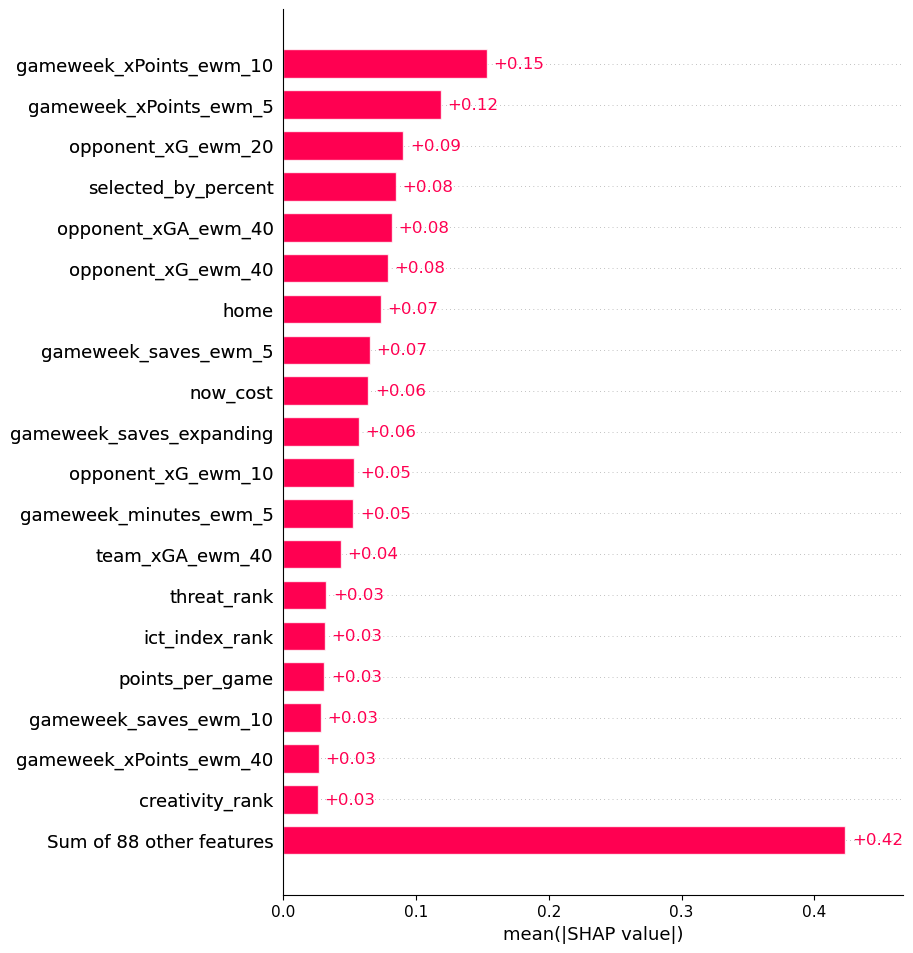

In [26]:
# Goalkeepers
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X[X.element_type==1]) #.sample(2000, random_state=42)
shap.plots.bar(shap_values, max_display=20)

## Misc: Model performance check

In [ ]:
season_folder = 'season24_25'
model_file_name = 'xgboost_20240813-184939.pkl'
path = Path(f'../models/{model_file_name}')
model = pickle.load(open(path, 'rb'))
display(model)

In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score

In [ ]:
# predictions
y_predicted = model.predict(X_train)

# measure performance
rmse_train = root_mean_squared_error(y_train, y_predicted)
print(f'RMSE (train): {rmse_train}')
r2_train = r2_score(y_train, y_predicted)
print(f'R^2 (train): {r2_train}')

# predictions
y_predicted = model.predict(X_test)        

# measure performance
rmse_test = root_mean_squared_error(y_test, y_predicted)
print(f'RMSE (test): {rmse_test}')
r2_test = r2_score(y_test, y_predicted)
print(f'R^2 (test): {r2_test}')